<a href="https://colab.research.google.com/github/miles-garcia/DSPS_MGarcia/blob/main/FitLineToGRBAfterGlow_mcmc_MGarcia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fitting a line to GRB afterglow photometry

This exercise teaches you to fit the simplest model to data: a line, using different methods.

Notes:

    a line is a power law in log-log space. The GRB afterglow is generated by a powerlaw process
    
    we will learn later that a broken powerlaw is a prefer model for the GRB afterglow. But this exercise is about fitting lines: Linear Regression
    

# initial imports

In [3]:
import pandas as pd
import pylab as pl
%pylab inline
import scipy as sp



Populating the interactive namespace from numpy and matplotlib


# Read in the input dataset
I am reading the data with Pandas. Pandas has excellent utilities for input-output of tabular data and also for time variables. We will use it throughout as our main package to acquire and manipulate data

In [4]:
grbAG = pd.read_csv("https://raw.githubusercontent.com/fedhere/DSPS_FBianco/main/data/grb050525A.csv")
grbAG.head()
grbAG_nolim = grbAG[grbAG.upperlimit==0]

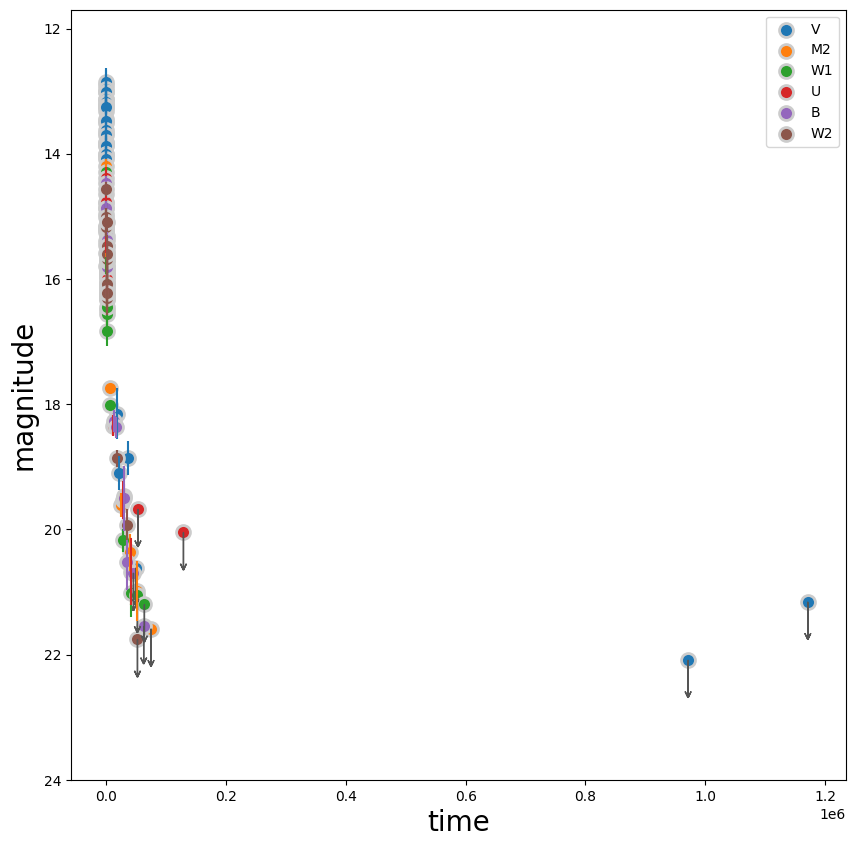

In [5]:
#create a figure container and an axis object inside of it
ax = pl.figure(figsize=(10,10)).add_subplot(111)

#loop on every filter to plot - this will give differnt colors naturally.
#Use pl.errorbar to plot the uncertainties

for f in grbAG["filter"].unique():
    pl.errorbar(grbAG.loc[grbAG["filter"] == f, "time"],
                grbAG.loc[grbAG["filter"] == f, "mag"],
                yerr=grbAG.loc[grbAG["filter"] == f, "magerr"],
                fmt='.', ms=0,
                fcolor=None, label=None)

# replot to add a better marker (optional)
for f in grbAG["filter"].unique():
    pl.scatter(grbAG.loc[grbAG["filter"] == f, "time"],
               grbAG.loc[grbAG["filter"] == f, "mag"],
               alpha=1, s=100, linewidth=2,
               label=f,
               edgecolor='#cccccc')


# plot the upperlimits as arrows
nuplim = grbAG.mag.isna().sum()
for i in grbAG[grbAG.upperlimit == 1].index:
    pl.arrow(grbAG.loc[i].time,
             grbAG.loc[i].mag, 0, 0.5, head_width=1e4,
             overhang=1, shape="full",
             head_length=0.1, ec='#555555', visible=True)

# I am going to invert the y axis because the "magnitude" measurement is an inverse scale: brighter is smaller
pl.ylim(24,11.7)
pl.legend()

#Always rememebr you axis labels!!
pl.ylabel("magnitude", fontsize=20)
pl.xlabel("time", fontsize=20);

# Create the log-time variable

We will fit a line in log space. That corresponds to fitting a powerlaw y=x^a in natural space.


In [6]:
grbAG["logtime"] = np.log10(grbAG["time"])
grbAG_nolim["logtime"] = np.log10(grbAG_nolim["time"])
grbAG.head()

<ipython-input-6-993237b36d70>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grbAG_nolim["logtime"] = np.log10(grbAG_nolim["time"])


,filter,time,mag,magerr,upperlimit,logtime
0,V,66,13.21,0.24,0,1.819544
1,V,67,12.90,0.23,0,1.826075
2,V,68,12.86,0.23,0,1.832509
3,V,69,13.01,0.23,0,1.838849
4,V,70,12.97,0.23,0,1.845098


In [7]:
grbAG_nolim.head()

,filter,time,mag,magerr,upperlimit,logtime
0,V,66,13.21,0.24,0,1.819544
1,V,67,12.90,0.23,0,1.826075
2,V,68,12.86,0.23,0,1.832509
3,V,69,13.01,0.23,0,1.838849
4,V,70,12.97,0.23,0,1.845098


# Visualize the data
The data are photometric measurements: measurement of flux from an exploding star. The flux is measured in different photometric bands, i.e. within different wavelength range. You can think about this as a filter that would limit the light collected by a camera to a single color, e.g. red, blue, or green. In most all cameras (your phone camera for example) collect data in RGB bands saparately and combine them to create a "color picture". Our eyes also perceive color in 3 bands, R, G, B.

The information about the photometric band is stored in the variable ```grbAG.filter```. Plot the data with different colors for different photometric bands.

In [88]:
def plotlogtime(df, models=[]):
  '''
  plot the GRB afterglow data (not including upper limits) on log log axes with fun and cool data visualization stuff
  '''
  #create a figure container and an axis object inside of it
  ax = pl.figure(figsize=(10,10)).add_subplot(111)

  #loop on every filter to plot - this will give differnt colors naturally.
  #Use pl.errorbar to plot the uncertainties

  for f in grbAG_nolim["filter"].unique():
    pl.errorbar(grbAG_nolim.loc[grbAG_nolim["filter"] == f, "logtime"],
                grbAG_nolim.loc[grbAG_nolim["filter"] == f, "mag"],
                yerr=grbAG_nolim.loc[grbAG_nolim["filter"] == f, "magerr"],
                fmt='.', ms=0,
                fcolor=None, label=None)

  # replot to add a better marker (optional)
  for f in grbAG_nolim["filter"].unique():
    pl.scatter(grbAG_nolim.loc[grbAG_nolim["filter"] == f, "logtime"],
               grbAG_nolim.loc[grbAG_nolim["filter"] == f, "mag"],
               alpha=1, s=100, linewidth=2,
               label=f,
               edgecolor='#cccccc')


  # plot the upperlimits as arrows
  '''
  nuplim = grbAG.mag.isna().sum()
  for i in grbAG[grbAG.upperlimit == 1].index:
    pl.arrow(grbAG.loc[i].logtime,
             grbAG.loc[i].mag, 0, 0.5, head_width=0.1,
             overhang=1, shape="full",
             head_length=0.1, ec='#555555', visible=True)
'''
  # I am going to invert the y axis because the "magnitude" measurement is an inverse scale: brighter is smaller
  pl.ylim(24,11.7)
  pl.legend()

  #Always rememebr you axis labels!!
  pl.ylabel("magnitude", fontsize=20)
  pl.xlabel("log time", fontsize=20)
  return ax

In [87]:
def plotlogtime_wUL(df, models=[]):
  '''
  same as above but include the upper limit values and plot them as arrows.
  '''
  #create a figure container and an axis object inside of it
  ax = pl.figure(figsize=(10,10)).add_subplot(111)

  #loop on every filter to plot - this will give differnt colors naturally.
  #Use pl.errorbar to plot the uncertainties

  for f in grbAG["filter"].unique():
    pl.errorbar(grbAG.loc[grbAG["filter"] == f, "logtime"],
                grbAG.loc[grbAG["filter"] == f, "mag"],
                yerr=grbAG.loc[grbAG["filter"] == f, "magerr"],
                fmt='.', ms=0,
                fcolor=None, label=None)

  # replot to add a better marker (optional)
  for f in grbAG["filter"].unique():
    pl.scatter(grbAG.loc[grbAG["filter"] == f, "logtime"],
               grbAG.loc[grbAG["filter"] == f, "mag"],
               alpha=1, s=100, linewidth=2,
               label=f,
               edgecolor='#cccccc')


  # plot the upperlimits as arrows

  nuplim = grbAG.mag.isna().sum()
  for i in grbAG[grbAG.upperlimit == 1].index:
    pl.arrow(grbAG.loc[i].logtime,
             grbAG.loc[i].mag, 0, 0.5, head_width=0.1,
             overhang=1, shape="full",
             head_length=0.1, ec='#555555', visible=True)

  # I am going to invert the y axis because the "magnitude" measurement is an inverse scale: brighter is smaller
  pl.ylim(24,11.7)
  pl.legend()

  #Always rememebr you axis labels!!
  pl.ylabel("magnitude", fontsize=20)
  pl.xlabel("log time", fontsize=20)
  return ax

<Axes: xlabel='log time', ylabel='magnitude'>

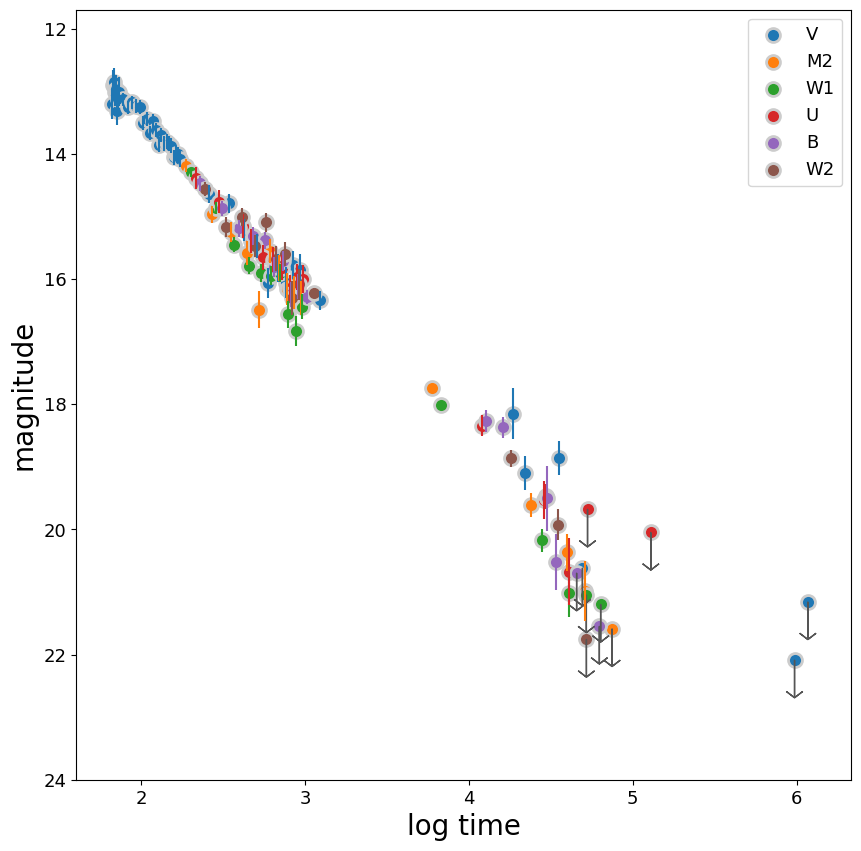

In [82]:
plotlogtime_wUL(grbAG)

Figure 1: Photometry of the Afterglow of GRB 052505A. All photometry is from the Swift satellite and it is obtained from Table 3 of Blustin et al. 2005 https://arxiv.org/pdf/astro-ph/0507515.pdf. The photometric band for each datapoint is indicated in the legend. Time is relative from the estimated moment of explosion of the stellar progenitor. Upperlimits are indicated by down-pointing arrows.

# Solve using the Normal Equation

It can be shown that the best linear fit to data is given by the equation:  

$(X^T \cdot X)^{-1} \cdot X^T \cdot \vec{y}$

The solution is a tuple of 2 parameters: sloper and intercept. Therefore the input has to be Nx2


In [10]:
x = grbAG[grbAG.upperlimit == 0].logtime.values
X = np.c_[np.ones((len(grbAG) - grbAG.upperlimit.sum(), 1)),
          x]


y = grbAG.loc[grbAG.upperlimit == 0].mag.values
print("shape of the input array X", X.shape)
print("shape of the input array y", y.shape)
#note the shape in python is flipped compared to the shape in linear algebra

shape of the input array X (108, 2)
shape of the input array y (108,)


In [11]:
theta_best = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)
print ("best fit parameters from the Normal Equation: " +
       "intercept {:.2f}, slope {:.2f}".format(*theta_best))

best fit parameters from the Normal Equation: intercept 8.58, slope 2.51


# Fit a line to the data (excluding the upper limits) with sklearn LinearRegression

The exogenous (independent) variable is ```grbAG.logtime```.

The information about whether the point is an upper limit or a measurement is stored in the variable ```grbAG.upperlimit```.
To remove the upper limits you can "broadcast" the data: in pandas that looks like

```grbAG.loc[grbAG.upperlimit == 0]```



In [12]:
#note: imports should be moved to the top cell - follow PEP8 guidelines
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(X,y)

lr.coef_, lr.intercept_

(array([0.        , 2.51199984]), 8.582668233648771)

##Below: Train Test Split

In [13]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test  = train_test_split(
     X, y, test_size=0.25, random_state=69)

In [14]:
reg = LinearRegression()
reg.fit(x_train,y_train)
train_score = reg.score(x_train,y_train)
reg.fit(x_test,y_test)
test_score = reg.score(x_train,y_train)

print("Training Set Fit Score: {:.5f} \nTest Set Fit Score: {:.5f}".format(train_score,test_score))
print("Test value for slope: {:.3f} \nTest Value for intercept: {:.3f}".format(reg.coef_[1], reg.intercept_))

Training Set Fit Score: 0.96950 
Test Set Fit Score: 0.96503
Test value for slope: 2.415 
Test Value for intercept: 8.802


# Fit a line to the data (excluding the upper limits) by minimizing an objective function

First, choose the L1 and L2 metric (see class notes) as the objective function.

Use ```scipy.optimize.minimize()``` to minimize it.


In [84]:
#note: imports should be moved to the top cell - follow PEP8 guidelines
from scipy.optimize import minimize

def line(intercept, slope, x):
  '''
  this makes a line given a slope, intercept, and x value(s)
  '''
  return slope*x+intercept
def l1(args, x, y):
  '''
  L1 loss function: sum of differences between real data and line fit using given parameters
  '''
  sum = 0
  for i in range(len(x)):
    pred = line(args[1],args[0],x[i])
    real = y[i]
    dist = np.absolute(real-pred)
    sum = sum+dist
  return sum


initialGuess = [1,1]

l1Solution = minimize(l1, initialGuess, args=(x, y))
print(l1Solution)
print("")
print("best fit parameters from the minimization of L1: " +
       "slope {:.2f}, intercept {:.2f}".format(*l1Solution.x))

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 26.303314305267417
        x: [ 2.641e+00  8.225e+00]
      nit: 17
      jac: [ 7.153e-07  0.000e+00]
 hess_inv: [[ 9.432e-06 -2.183e-05]
            [-2.183e-05  5.455e-05]]
     nfev: 174
     njev: 58

best fit parameters from the minimization of L1: slope 2.64, intercept 8.23


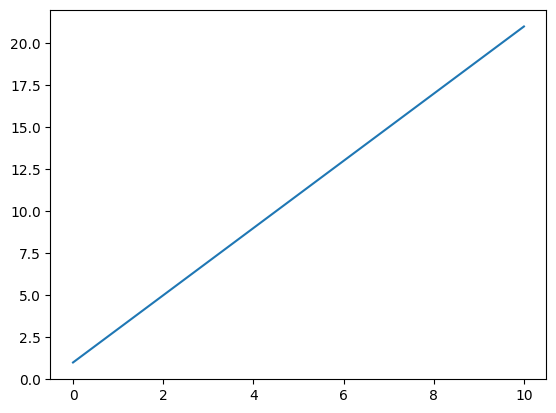

In [16]:
xs = np.linspace(0,10,1000)

plt.plot(xs,line(1,2,xs)) #just checking that line works

In [85]:

def l2(args, x, y):
  '''
  L2: same as L1 but square the differences
  '''
  sum = 0
  for i in range(len(x)):
    pred = line(args[1],args[0],x[i])
    real = y[i]
    dist = (np.absolute(real-pred))**2
    sum = sum+dist
  return sum

initialGuess = [1,1]

l2Solution = minimize(l2, initialGuess, args=(x, y))
print(l2Solution)
print("")
print("best fit parameters from the minimization of L2: " +
       "slope {:.2f}, intercept {:.2f}".format(*l2Solution.x))

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 12.82598750072535
        x: [ 2.512e+00  8.583e+00]
      nit: 5
      jac: [ 2.742e-06 -3.576e-07]
 hess_inv: [[ 7.114e-03 -2.030e-02]
            [-2.030e-02  6.254e-02]]
     nfev: 21
     njev: 7

best fit parameters from the minimization of L2: slope 2.51, intercept 8.58



# Fit a line to the data (excluding the upper limits) by minimizing an objective function that accounts for the measurements uncertainties

Since the data has uncertainty, choose the $\chi^2$ (chi squared) function as your objective function.

In [86]:
def chi2(args, x, y, s):
  '''
  chi2 loss function: same as L2 but divide each difference by the square of the error on the data point.
  '''
  sum = 0
  for i in range(len(x)):
    pred = line(args[1],args[0],x[i])
    real = y[i]
    dist = ((np.absolute(real-pred))**2)/(s[i])**2
    sum = sum+dist
  return sum

x = grbAG[grbAG.upperlimit == 0].logtime.values
y = grbAG.loc[grbAG.upperlimit == 0].mag.values
s = grbAG.loc[grbAG.upperlimit == 0].magerr.values

initialGuess = [1,1]

chi2Solution = minimize(chi2, initialGuess, args=(x, y, s))
print(chi2Solution)
print("")
print("best fit parameters from the minimization of the chi squared: " +
       "slope {:.2f}, intercept {:.2f}".format(*chi2Solution.x))

  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: 317.42066980130784
        x: [ 2.480e+00  8.599e+00]
      nit: 8
      jac: [ 3.815e-05  0.000e+00]
 hess_inv: [[ 5.969e-06 -1.045e-05]
            [-1.045e-05  1.828e-05]]
     nfev: 78
     njev: 26

best fit parameters from the minimization of the chi squared: slope 2.48, intercept 8.60


In [20]:
chi2Solution.x[::-1]

array([8.59948748, 2.48019101])

It didn't finish due to precision loss, but we can tell that the result is still pretty close to what we expect, so we'll just leave it. I tried changing the initial guesses and that didn't change anything so I just leave it.

# Plot all the solutions

Create a function that uses the parameters you input and plots a line. Add a legend that describes which line corresponds to what.


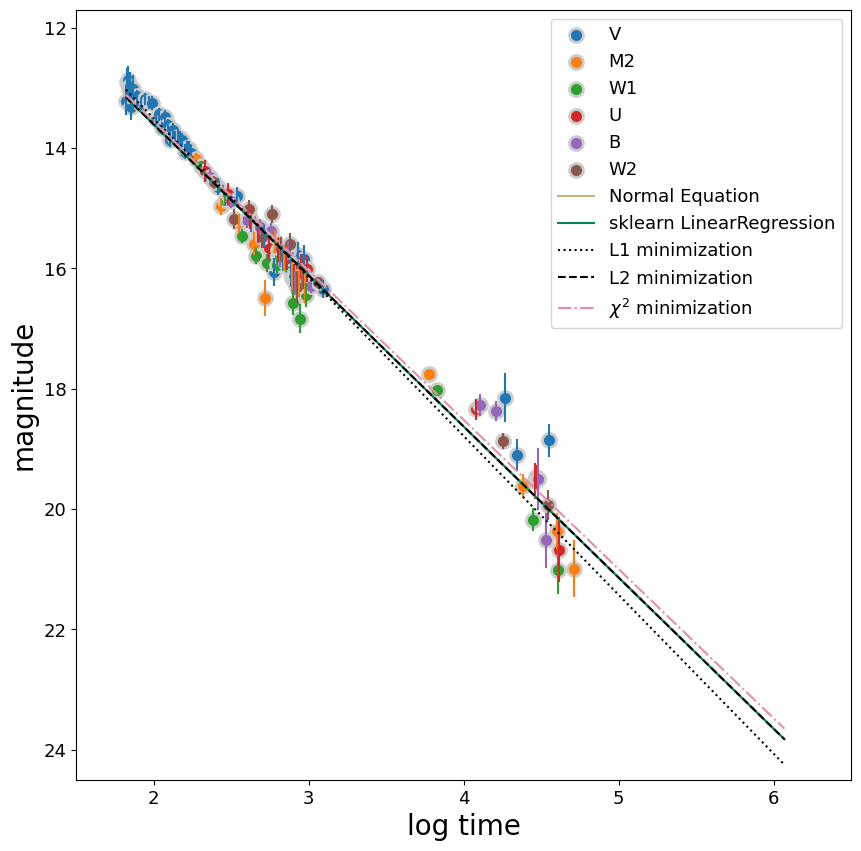

In [92]:
def plotline(pars, x, color='k', symbol='-', label='model',
             alpha=1, ax=ax):
    '''
    plot a line from slope and intercept with cool colors and labels
    '''
    slope, intercept = pars
    y = line(intercept, slope, x)
    ax.plot(x, y, ls=symbol, c=color, label=label, alpha=alpha)


ax = plotlogtime(grbAG)
#plotting models
#use Kelley colors for maximum readability
#https://gist.github.com/ollieglass/f6ddd781eeae1d24e391265432297538
colors = ['C2B280', '848482', '008856', 'E68FAC', '0067A5', 'F99379',
          '604E97', 'F6A600', 'B3446C',
          'DCD300', '882D17', '8DB600', '654522', 'E25822', '2B3D26',
          '222222', 'F3C300', '875692', 'F38400', 'A1CAF1', 'BE0032', ]
#normal equation
plotline((theta_best[::-1]), grbAG.logtime.values,
         color='#'+colors[0],
         label="Normal Equation", ax=ax)

#sklearn
plotline((lr.coef_[1], lr.intercept_), grbAG.logtime,
         color='#'+colors[2], symbol='-',
         label="sklearn LinearRegression", ax=ax)

#minimize L1
plotline((l1Solution.x), grbAG.logtime,
         symbol=':',
         label="L1 minimization", ax=ax)
#minimize L2
plotline((l2Solution.x), grbAG.logtime,
         symbol='--',
         label="L2 minimization", ax=ax)
#minimize chi2
plotline((chi2Solution.x), grbAG.logtime,
         color='#'+colors[3], symbol='-.',
         label=r"$\chi^2$ minimization", ax=ax)

pl.legend()

#with the LinearRegression object I can also do
#pl.plot(grbAG.logtime, lr.predict(np.c_[np.ones((len(grbAG), 1)), grbAG.logtime]), 'k-')

pl.ylim(24.5,11.7)
pl.xlim(1.5, 6.5)
pl.ylabel("magnitude", fontsize=20)
pl.xlabel("log time", fontsize=20);


Figure 2: Same as Figure 1, but with linear regression models plotted. The models correspond to the best fit line to the data (excluding upper limits) calculated analytically by solving the normal equation, by solving the fit analysitcally with sklearn.LinearRegression(), and by minimizing the objective functions L1 and Chi squared. The models are indicated in the legend.

# HW part 1: redo the sklearn model with a train-test split of the data

- choose the train-test rations that you prefer
- get the score for the model when predicting on the train data and on the test data
- what can you say about the model by comparing the two scores?

Done above at the same part as the original sklearn

# Now try a line to the data with MCMC

# HW part 2: write captions for each figure. The figures are produced by my code. The captions should state:
- what is plotted
- what is noticeable or interesting in the figure



In [22]:
!pip install emcee # install the emcee package that implements the _affine invariant MCMC_ method

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.2/46.2 kB 2.2 MB/s eta 0:00:00


In [23]:
import emcee #import the package

In [24]:
emcee

<module 'emcee' from '/usr/local/lib/python3.10/dist-packages/emcee/__init__.py'>

look at documentation: https://emcee.readthedocs.io/en/stable/

We are implementing Bayes theorem to find the best model parameters: $P(\theta | D) ~ P(D | \theta) * P(\theta)$ or _Posterior ~ Likelihood * Prior_

Since we are maximizing the likelihood, we work in log space because:
- the logarithm is a monotonic function of its argument (meaning where the argument gets bigger its log gets bigger, where it gets smaller its log gets smaller)
- the log is not defined for negative values (log(something < 0) is undefined) but this does not matter because the likelihood is a probability and probabilities are positive defined.



In [94]:
# LINE MODEL
def log_prior(theta):
  '''
  semi informative prior: i know light has to get fainter (mag get bigger), and i know i dont use negative mags
  '''
  slope, intercept = theta
  if slope > 0 and intercept > 0:
    return 0

  return -np.inf


In [95]:
#log likelihood
def log_likelihood(theta, x, y, yerr):
  '''
  use chi2 to calculate likelihoods
  '''
  slope, intercept = theta
  #chi2 likelihood : (data-model)**2 / uncertainty **2
  return np.sum(((y - line(intercept, slope, x))**2) / yerr**2)

In [96]:
#log posterior
def log_probability(theta, x, y, yerr):
  '''
  log posterior is just log prior + neg log likelihood = lp - log likelihood
  '''
  lp = log_prior(theta)
  if not np.isfinite(lp):
    return -np.inf
  # posterior ~ likelihood * prior => log_posterior ~ log_likelihood + log_prior
  return lp - log_likelihood(theta, x, y, yerr)

In [28]:
#initial guess
ig = [1,10]

In [29]:
#initialize N walkers
nwalkers = 32
ndim = len(ig)

In [30]:
pos = np.array(ig) + 1e-4 * np.random.randn(nwalkers, ndim) #the starting point for each walker is a small perturbation of the initial guess

In [31]:
pos.shape

(32, 2)

In [32]:
# this sets up the model and assignes the hyperparameters
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(x, y, s))

In [33]:
# this runs the MCMC for 5,000 steps
sampler.run_mcmc(pos, 5000, progress=True);

100%|██████████| 5000/5000 [00:12<00:00, 387.54it/s]


In [34]:
# this extracts the ergodic markovian chains of positions in the feature space
samples = sampler.get_chain()

In [35]:
samples.shape

(5000, 32, 2)

In [36]:
# to get statistical properties of the chains I will concatenate the 32 chains. This works _iff_ the chains are independent
# note: the chains are _assumed_ to be independent
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)

In [37]:
#the result of the mcmc (the best parameters and their uncertainties) are statistical properties of the chains
# I recommand the median and percentiles over the mean and standard deviation, since the chains need not be gaussian
mcmc = np.zeros((ndim, 3))
for i in range(ndim):
  mcmc[i] = np.percentile( flat_samples[:,i], [16, 50, 84])
mcmc

array([[2.46582878, 2.47991641, 2.49406739],
       [8.56094218, 8.60025557, 8.63923605]])

In [100]:
mcmc[:,1]

array([2.47991641, 8.60025557])

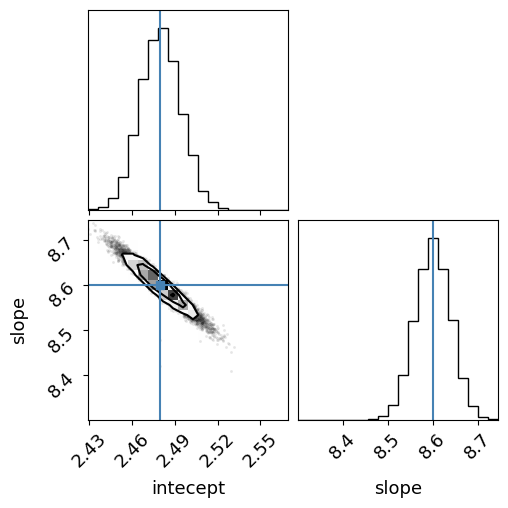

In [38]:
#plotting the likelihood space: the panels are 2D projections of the feature space and 1D marginalized probabilities for each parameters
!pip install corner
import corner
pl.rcParams["font.size"]= 13
fig = corner.corner(
    flat_samples, labels=["intecept", "slope"], truths=mcmc[:,1]);


Figure 3: Corner plot showing the results of MCMC. The lower left plot shows the combined region investigated by the MCMC samplers in slope and intercept space (joint prob distribution), where more time was spent at the more likely values for both slope and intercept (highlighted by the blue lines is the most probable value). The top left and lower right plots show the individual probability density (marginal PDF) for intercept and slope respectively.
The lower left plot being fairly thin but long shows that there is correlation between slope and intercept-- having one value of intercept gives you a very likely (small) range of values for the slope and vice versa.

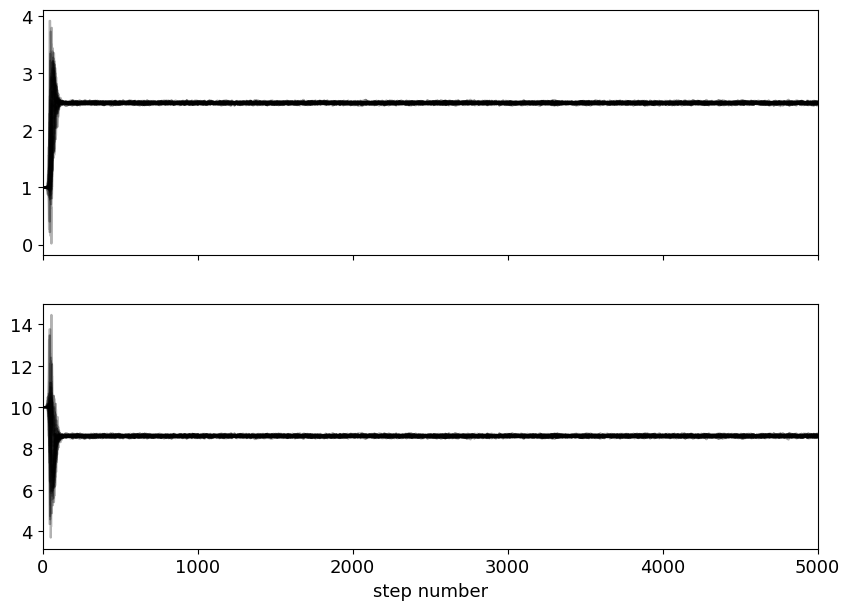

In [39]:
# the chains should be plotted as well. in the slides and in class I discuss what you should expect them to look like
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()

for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

Figure 4: This shows the full MCMC chains for all 32 samplers/walkers for slope (top) and intercept (bottom). For each step of the walker, the value it is at for slope and intercept are plotted. We can see that even though the initial guesses were not close to the values the MCMC favor, the walkers converge on the favored area fairly quickly and then stay there for most of the steps-- there's very little variation after step ~200 (or even less).

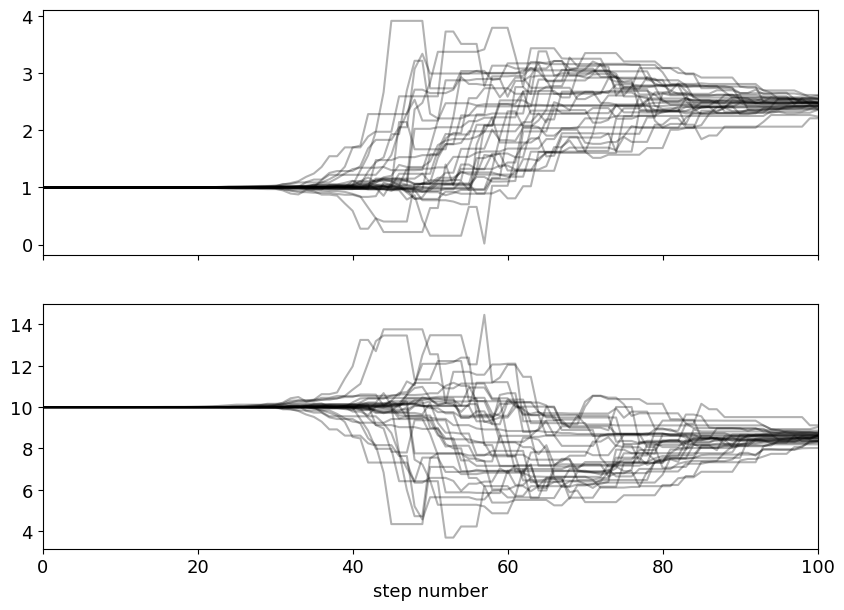

In [40]:
# zoom in: the beginnign of the chane should be cut - this is the burn-in part of the chain
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()

for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, 100)#len(samples))
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

Figure 5: The burn-in phase for the walkers for both slope and intercept. Again, this plot shows the value for slope and intercept for each walker at each step, but only for the first hundred steps. This is the region where the walkers are exploring the space the most, starting at the initial guesses and moving towards the most favored values. We can see much more variation in the walkers here compared to the next 4900 steps, but these values don't mean much since the walkers are still moving from the initial guesses to the values the MCMC favors.

In [41]:
# save the mcmc results for later
mcmc_line = mcmc

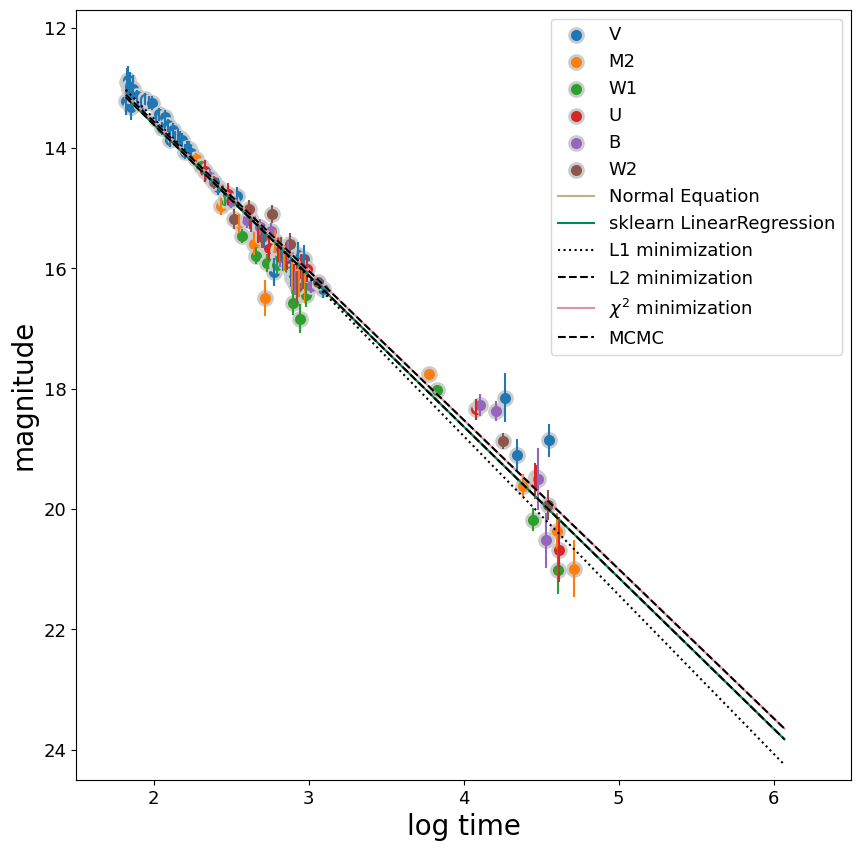

In [111]:
def plotline(pars, x, color='k', symbol='-', label='model',
             alpha=1, ax=ax):
    '''
    plot a line from slope and intercept with cool colors and labels
    '''
    slope, intercept = pars
    y = line(intercept, slope, x)
    ax.plot(x, y, ls=symbol, c=color, label=label, alpha=alpha)


ax = plotlogtime(grbAG)
#plotting models
#use Kelley colors for maximum readability
#https://gist.github.com/ollieglass/f6ddd781eeae1d24e391265432297538
colors = ['C2B280', '848482', '008856', 'E68FAC', '0067A5', 'F99379',
          '604E97', 'F6A600', 'B3446C',
          'DCD300', '882D17', '8DB600', '654522', 'E25822', '2B3D26',
          '222222', 'F3C300', '875692', 'F38400', 'A1CAF1', 'BE0032', ]
#normal equation
plotline((theta_best[::-1]), grbAG.logtime.values,
         color='#'+colors[0],
         label="Normal Equation", ax=ax)

#sklearn
plotline((lr.coef_[1], lr.intercept_), grbAG.logtime,
         color='#'+colors[2], symbol='-',
         label="sklearn LinearRegression", ax=ax)

#minimize L1
plotline((l1Solution.x), grbAG.logtime,
         symbol=':',
         label="L1 minimization", ax=ax)
#minimize L2
plotline((l2Solution.x), grbAG.logtime,
         symbol='--',
         label="L2 minimization", ax=ax)
#minimize chi2
plotline((chi2Solution.x), grbAG.logtime,
         color='#'+colors[3], symbol='-',
         label=r"$\chi^2$ minimization", ax=ax)


plt.plot(grbAG.logtime,line(mcmc[:,1][1],mcmc[:,1][0],grbAG.logtime),color='k',label='MCMC',ls = '--')

pl.legend()

#with the LinearRegression object I can also do
#pl.plot(grbAG.logtime, lr.predict(np.c_[np.ones((len(grbAG), 1)), grbAG.logtime]), 'k-')

pl.ylim(24.5,11.7)
pl.xlim(1.5, 6.5)
pl.ylabel("magnitude", fontsize=20)
pl.xlabel("log time", fontsize=20);


Figure 6: Same as Fig. 2 but including the MCMC model, which lines up really well with the Chi^2 minimization result.

# HW part 3

# Now try a broken power law (BPL) model

A power la is not a good model for GRB afterglows. A broken power law has been known to be a better model and has several physical motivations. In this exercise you will fit a _broke power law_ to the data, which is a more complex and higher dimensional model than the simple line fit we did so far, with MCMC getting best values for the posterior, a complete characterization of the likelihood, and allowing model selection between the line and the power law.

> Here is some info that talks about the power law model and the phsyics of GRB, which you need not know to solve the assignment but you may be interested in.  A broken power law is a power law ($y ~ x^a$) where the power a changes at some point. This can be caused by the presence of two power law processes with different, for example, where one dominates at early time and the other at late times.


>> Here is some more info that explains why we observed the GRB afterglows as broken power laws.
>>Gamma-ray bursts (GRBs) are produced by the collapse of massive stars or the merger of compact objects like neutron stars. The energy of the collapse is highly energetic (Gamma rays) but the emission gets reprocessed as it leaves the system and looses energy becoming detectable in the optical wavelengths. This is called the "optical afterglow of the GRB".
>>The explosion resulting from the collapse generates a highly relativistic outflow of material that moves at a significant fraction of the speed of light.
>> The afterglow emission is primarily produced through synchrotron radiation, where charged particles spiral around magnetic field lines. The radiation produced by synchrotrone follows a power law with an index that depends on the density of the surrounding medium, the Lorentz factor of the outflow, and the magnetic field strength. As the radiation crosses different regions of the system that collapsed these factors change and the powerlaw index changes with them.

>>If the relativistic outflow is highly collimated (a jet) as the jet expands, its emission can be modeled as a power-law light curve, but  where the jet begins to decelerate and spread out the slope of the power law changes. This transition is known as the "jet break" and results in a broken power-law behavior.

>> Some GRBs exhibit late-time flares or additional energy injection from the central engine but we are not modeling this in this exercise.




_BPL model variables:_

$F = \mathrm{flux}$ - note: not magnitude this time! $mag ~ -2.5log10(Flux)$

$t =  \mathrm{time}$ - note: not log time

_BPL model parameters:_


$T_b =  \mathrm{Time~of~break}$

$a_1:  \mathrm{Early~slope}$

$a_2: \mathrm{Late~slope}$

$b:  \mathrm{nuisance~parameters}$

_BPL model_:

in flux space the BPL model is:
$F=\frac{F_0}{ \frac{t}{T_b}^{-a1} + \frac{t}{T_b}^{-a2}}$

in magnitude space (the data you want to predict is in magnitude and the equation is simple to minimize in log space) that is:

$mag = b - log_{10}\left((\frac{t}{T_b})^{-a1} + (\frac{t}{T_b})^{-a2})\right) $



In [42]:
t = grbAG[grbAG.upperlimit == 0].time.values

In [43]:
t.min(), t.max()

(66, 51257)

# HW part 3 task 1:
create the model `bpl()`, the `log_likelihood()`, `log_prior()` (choose what you want to set your prior to), and `log_posterior()`

In [112]:
def bpl (theta, t):
  '''
  defines a broken power law model that breaks at t_b, with two slopes a1 and a2, and nusiance parameter b. takes the t value(s) as time inputs.
  '''
  b,a1,t_b,a2 = theta
  return b-np.log10((t/t_b)**(-a1)+(t/t_b)**(-a2))

In [114]:
def log_likelihood_bpl(theta,t,y,yerr):
  return np.sum(((y - bpl(theta,t))**2) / yerr**2)
  '''
  same log likelihood as before.
  '''

def log_prior_bpl(theta):
  '''
  semi informative prior: i know light has to get fainter (mag get bigger)
  i know i dont use negative mags
  also t_b should be > 0 cuz negative time isnt relevant here
  '''
  b,a1,t_b,a2 = theta
  if a1 > 0 and a2 > 0 and t_b > 0:
    return 0

  return -np.inf
def log_posterior_bpl(theta, x, y, yerr):
  '''
  same log posterior as before.
  '''
  lp = log_prior_bpl(theta)
  if not np.isfinite(lp):
    return -np.inf
  # posterior ~ likelihood * prior => log_posterior ~ log_likelihood + log_prior
  return lp - log_likelihood_bpl(theta, x, y, yerr)

# HW part 3 task 2:
Find the initial starting point as a stochastic gradient descent minimization of the log likelihood

In [46]:

ixg = [0.2, 5, 1000, 20]
#what does the minimize function need to take as arguments?
soln = minimize(log_likelihood_bpl,ixg,args=(t,y,s))
soln

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 217.46531455531436
        x: [ 1.505e+01  3.548e+00  2.736e+02  2.146e+00]
      nit: 85
      jac: [-1.907e-06  3.815e-06  5.722e-06  1.907e-06]
 hess_inv: [[ 1.802e-04  3.554e-04  5.368e-04 -1.410e-04]
            [ 3.554e-04  2.377e-03  5.429e-03 -4.283e-04]
            [ 5.368e-04  5.429e-03  9.715e-02  1.300e-03]
            [-1.410e-04 -4.283e-04  1.300e-03  3.292e-04]]
     nfev: 590
     njev: 118

Text(0.5, 0, 'log time')

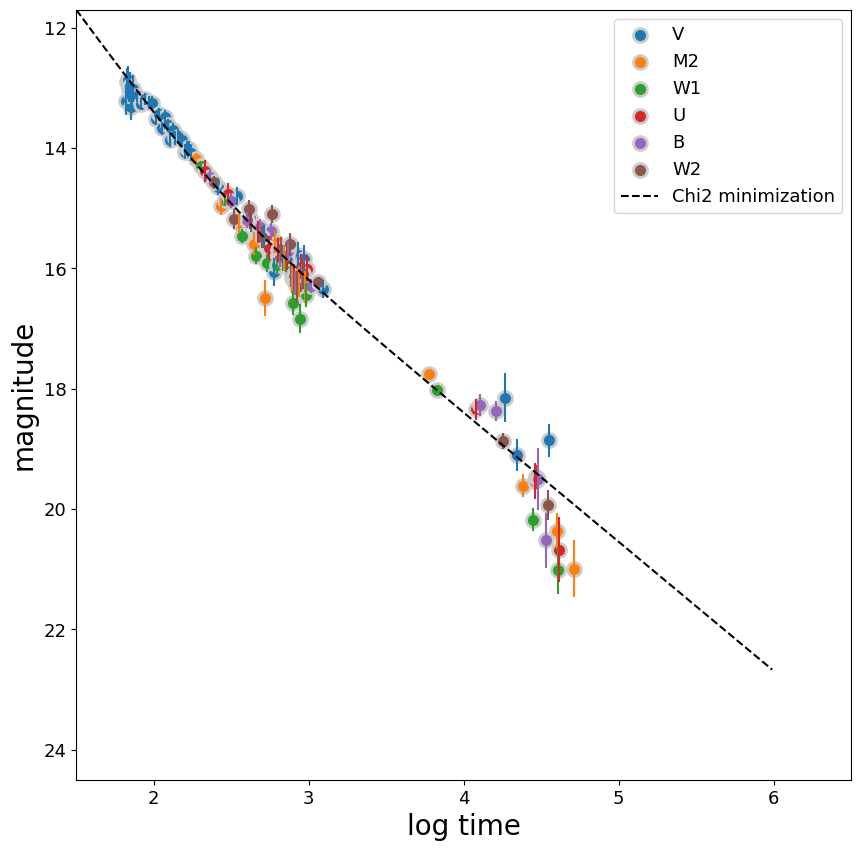

In [115]:
labels = ["intercept","slope"]
ax = plotlogtime(grbAG)
#plotting models
#use Kelley colors for maximum readability
#https://gist.github.com/ollieglass/f6ddd781eeae1d24e391265432297538
colors = ['C2B280', '848482', '008856', 'E68FAC', '0067A5', 'F99379',
          '604E97', 'F6A600', 'B3446C',
          'DCD300', '882D17', '8DB600', '654522', 'E25822', '2B3D26',
          '222222', 'F3C300', '875692', 'F38400', 'A1CAF1', 'BE0032', ]

ax.plot(np.arange(1.5,6,0.01),
        bpl(soln.x, 10**np.arange(1.5,6,0.01)), ls="--", c="k",
        label="Chi2 minimization")

pl.legend()

#with the LinearRegression object I can also do
#pl.plot(grbAG.logtime, lr.predict(np.c_[np.ones((len(grbAG), 1)), grbAG.logtime]), 'k-')

pl.ylim(24.5,11.7)
pl.xlim(1.5, 6.5)
pl.ylabel("magnitude", fontsize=20)
pl.xlabel("log time", fontsize=20)
#pl.plot(np.log(t),bpl(ig, t))

Figure 7: Data points for GRB afterglow with Chi^2 minimized parameters to broken power law model. We can see the break occuring right around the middle of the top-left data, and that the fit is pretty good by eye.

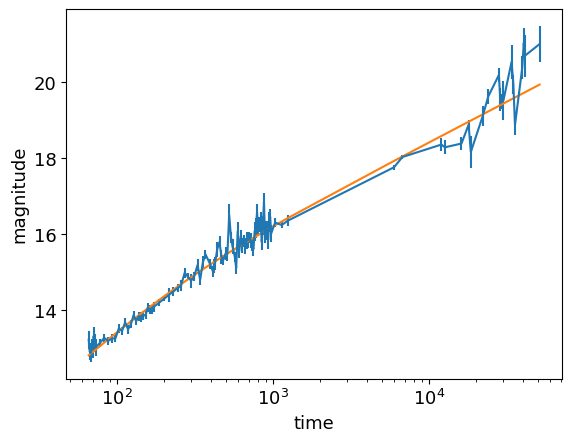

In [48]:
ig = soln.x # the initial guess for the MCMC

# plot the model as it looks with the initial guess values
pl.errorbar(t, y, yerr=s)
pl.plot(t,bpl(ig, t))
pl.xscale("log")
plt.ylabel("magnitude")
plt.xlabel("time")
plt.show()

Figure 8: Data visualized without flipping the y-axis and not making the points as visually nice, but this just gives us a sense of the "real" data because it's the actual direction of the power law-- increasing over time because increased magnitude = fainter. Again we get a good fit so we're inclined to accept the results of the stochastic gradient descent as a solid initial guess for our MCMC.

In [49]:
t

array([   66,    67,    68,    69,    70,    71,    72,    73,    78,
          83,    88,    93,    98,   103,   108,   113,   118,   123,
         128,   133,   138,   143,   148,   153,   158,   163,   168,
         173,   187,   202,   215,   229,   245,   258,   272,   286,
         299,   313,   329,   342,   356,   370,   397,   413,   419,
         426,   440,   455,   468,   482,   498,   511,   525,   539,
         552,   571,   582,   595,   609,   624,   637,   651,   666,
         680,   694,   708,   721,   735,   751,   764,   778,   792,
         805,   820,   835,   849,   863,   877,   890,   904,   920,
         933,   947,   961,   975,  1034,  1140,  1243,  5984,  6761,
       12019, 12671, 16182, 17973, 18575, 22163, 24007, 28111, 28664,
       29380, 30031, 33898, 34806, 35638, 39683, 40585, 41040, 51257])

# HW 3 task 3: optimize the model wit MCMC

- set the emcee hyperparameters
- run the chains
- extract the statistical properties of the chain as the best fit values
- plot the model
- plot the marginalized posteriors of the model parameters

In [50]:
# set the emcee hyperparameters


nwalkers_bpl, ndim_bpl = 32,len(ig)
pos_bpl = np.array(ig) + 1e-4 * np.random.randn(nwalkers_bpl, ndim_bpl)

sampler_bpl = emcee.EnsembleSampler(nwalkers_bpl, ndim_bpl, log_posterior_bpl, args=(t, y, s))

In [52]:
# run the model
sampler_bpl.run_mcmc(pos_bpl, 5000, progress=True);

100%|██████████| 5000/5000 [00:24<00:00, 202.80it/s]


In [53]:
ig

array([ 15.04715281,   3.5479759 , 273.58298131,   2.14569785])

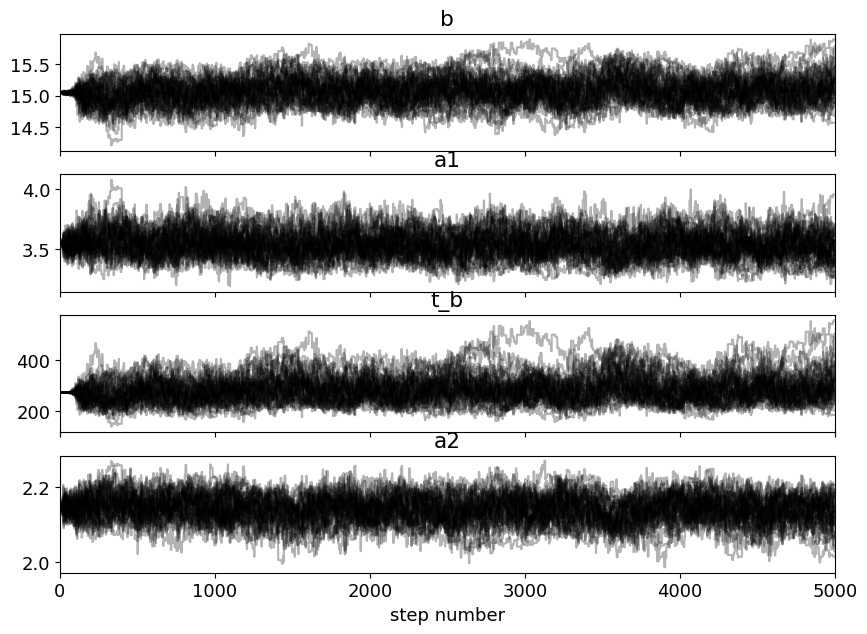

In [77]:
#plot the chains
fig, axes = plt.subplots(ndim_bpl, figsize=(10, 7), sharex=True)
samples_bpl = sampler_bpl.get_chain()

for i in range(ndim_bpl):
    ax = axes[i]
    ax.plot(samples_bpl[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples_bpl))
    ax.yaxis.set_label_coords(-0.1, 0.5)
axes[-1].set_xlabel("step number");
axes[0].set_title("b")
axes[1].set_title("a1")
axes[2].set_title("t_b")
axes[3].set_title("a2")
plt.show()

Figure 9: MCMC chains for the four parameters. The walkers look a bit crazier, but the y scales are quite small for most of the parameters, so theyre actually pretty much all agreeing within a small range for what the params should be. Only t_b is a little bit more wild since it's in a large range of values.

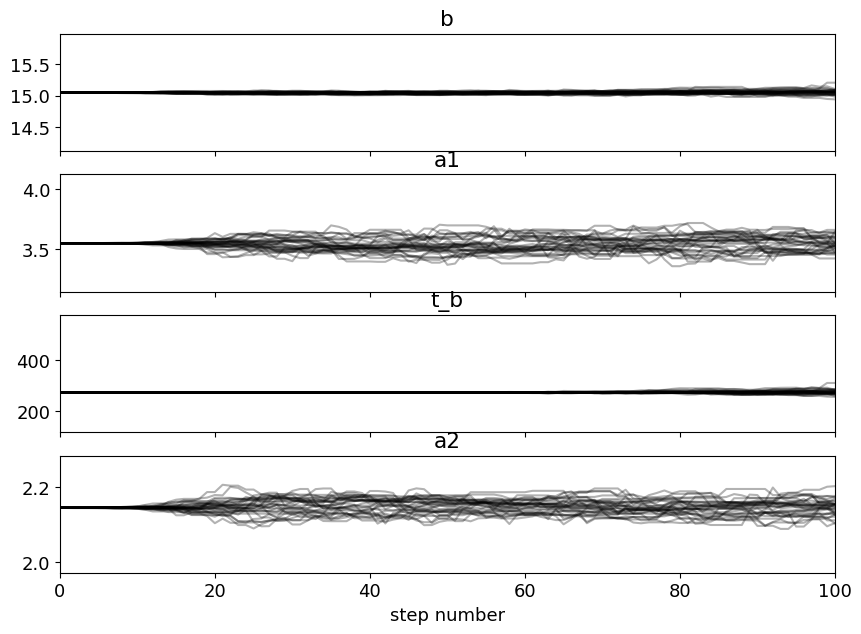

In [80]:

fig, axes = plt.subplots(ndim_bpl, figsize=(10, 7), sharex=True)
for i in range(ndim_bpl):
    ax = axes[i]
    ax.plot(samples_bpl[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples_bpl))
    ax.yaxis.set_label_coords(-0.1, 0.5)
    ax.set_xlim(0, 100)
axes[-1].set_xlabel("step number");
axes[0].set_title("b")
axes[1].set_title("a1")
axes[2].set_title("t_b")
axes[3].set_title("a2")
plt.show()

Figure 10: burn-in phase for each MCMC parameter. We can see that there really isnt a large amount of variation-- this is because our initial guesses from stochastic gradient descent are probably very close to the MCMC desired values, so the walkers tend not to move very much from the initial points, even during burn in.

In [55]:
# get the 16th, 50, and 84th percentiles of the model parameters
flat_samples_bpl = sampler_bpl.get_chain(discard=100, thin=15, flat=True)
mcmc_bpl = np.zeros((ndim_bpl, 3))
for i in range(ndim_bpl):
  mcmc_bpl[i] = np.percentile( flat_samples_bpl[:,i], [16, 50, 84])
mcmc_bpl[:,1]

array([ 15.07071834,   3.53526787, 279.08083957,   2.14300854])

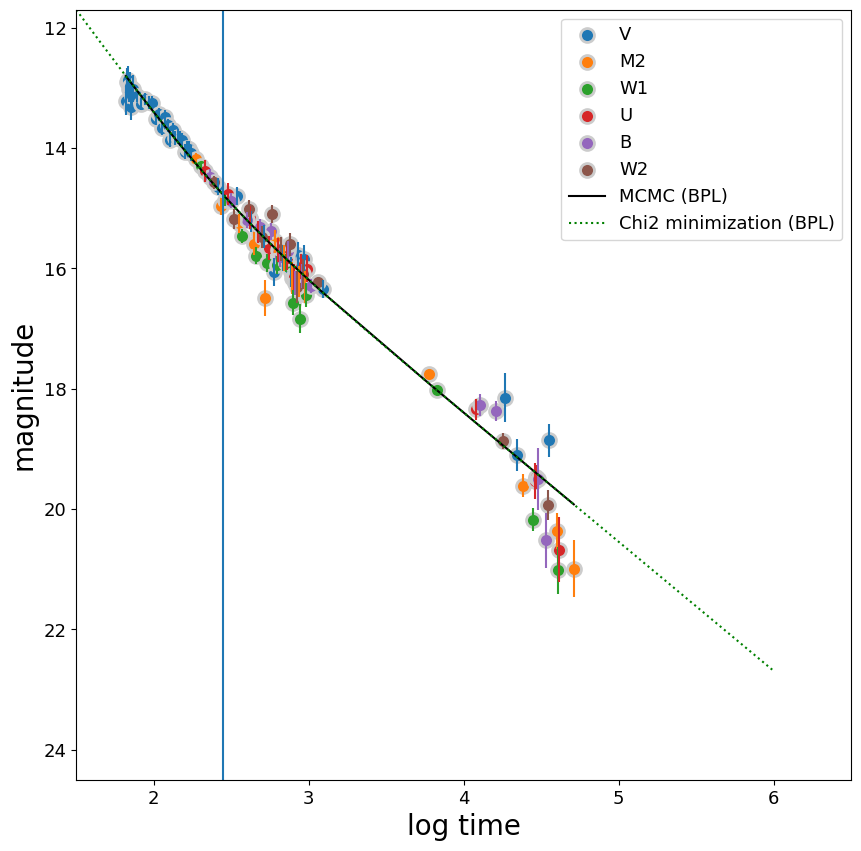

In [130]:
#plot the model
ax = plotlogtime(grbAG)

#plotting models
#use Kelley colors for maximum readability
#https://gist.github.com/ollieglass/f6ddd781eeae1d24e391265432297538
colors = ['C2B280', '848482', '008856', 'E68FAC', '0067A5', 'F99379',
          '604E97', 'F6A600', 'B3446C',
          'DCD300', '882D17', '8DB600', '654522', 'E25822', '2B3D26',
          '222222', 'F3C300', '875692', 'F38400', 'A1CAF1', 'BE0032', ]

ax.plot(grbAG_nolim.logtime.values, (bpl(mcmc_bpl[:,1],
                            10**grbAG_nolim.logtime.values)), ls="-", color = 'k', label="MCMC (BPL)")

ax.plot(np.arange(1.5,6,0.01),
        bpl(soln.x, 10**np.arange(1.5,6,0.01)), ls=":", color = 'g',
        label="Chi2 minimization (BPL)")



pl.legend()

#with the LinearRegression object I can also do
#pl.plot(grbAG.logtime, lr.predict(np.c_[np.ones((len(grbAG), 1)), grbAG.logtime]), 'k-')
pl.axvline(np.log10(mcmc_bpl[2,1]))
pl.ylim(24.5,11.7)
pl.xlim(1.5, 6.5)
pl.ylabel("magnitude", fontsize=20)
pl.xlabel("log time", fontsize=20);

Figure 11: GRB afterglow data with Chi2 minimization and MCMC BPL fits. We can see that these lines lie on top of each other which is what we expected from seeing the little change in the MCMC chains from the Chi2 initial guess. Blue vertical line represents MCMC t_b. The fits look pretty good.

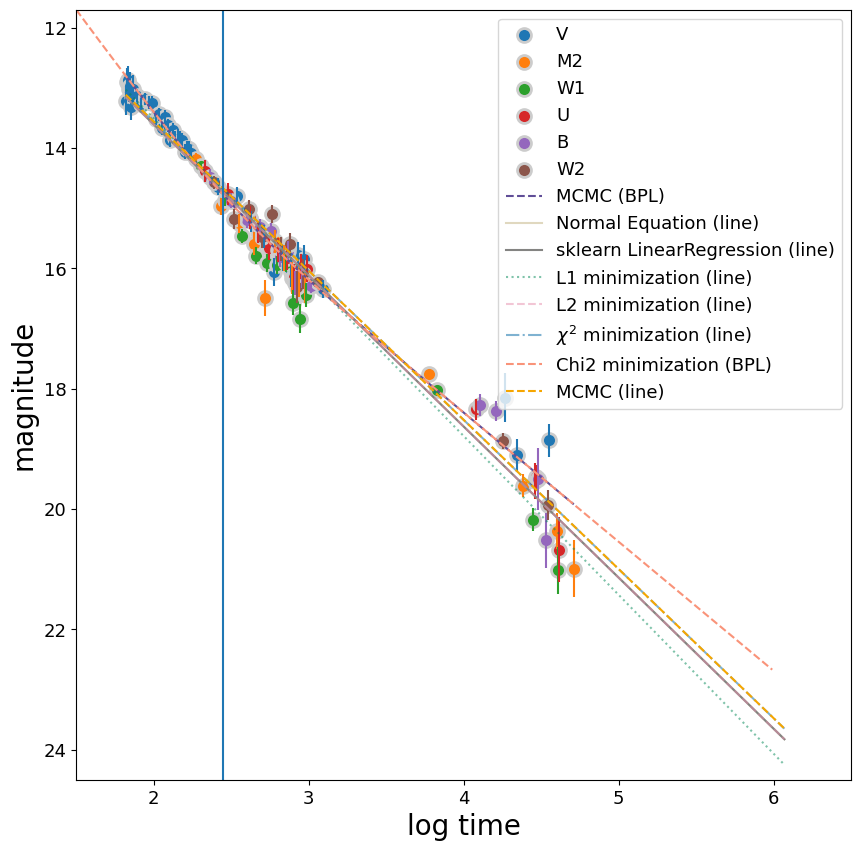

In [131]:
#plot the model
ax = plotlogtime(grbAG)

#plotting models
#use Kelley colors for maximum readability
#https://gist.github.com/ollieglass/f6ddd781eeae1d24e391265432297538
colors = ['C2B280', '848482', '008856', 'E68FAC', '0067A5', 'F99379',
          '604E97', 'F6A600', 'B3446C',
          'DCD300', '882D17', '8DB600', '654522', 'E25822', '2B3D26',
          '222222', 'F3C300', '875692', 'F38400', 'A1CAF1', 'BE0032', ]

ax.plot(grbAG_nolim.logtime.values, (bpl(mcmc_bpl[:,1],
                            10**grbAG_nolim.logtime.values)), ls="--", color = '#'+colors[6], label="MCMC (BPL)")


#normal equation
plotline((theta_best[::-1]), grbAG.logtime.values,
         color='#'+colors[0],  alpha=0.5,
         label="Normal Equation (line)", ax=ax)
#sklearn

plotline((lr.coef_[1], lr.intercept_), grbAG.logtime,
         color='#'+colors[1], symbol='-',
         label="sklearn LinearRegression (line)", ax=ax)
#minimize L1
plotline((l1Solution.x), grbAG.logtime,
         symbol=':', alpha=0.5, color='#'+colors[2],
         label="L1 minimization (line)", ax=ax)
#minimize L2
plotline((l2Solution.x), grbAG.logtime,
         symbol='--', alpha=0.5, color='#'+colors[3],
         label="L2 minimization (line)", ax=ax)
#minimize chi2
plotline((chi2Solution.x), grbAG.logtime,
         color='#'+colors[4], symbol='-.', alpha=0.5,
         label=r"$\chi^2$ minimization (line)", ax=ax)

ax.plot(np.arange(1.5,6,0.01),
        bpl(soln.x, 10**np.arange(1.5,6,0.01)), ls="--", color = '#'+colors[5],
        label="Chi2 minimization (BPL)")


plt.plot(grbAG.logtime,line(mcmc[:,1][1],mcmc[:,1][0],grbAG.logtime),'#'+colors[7],label='MCMC (line)',ls = '--')

pl.legend()

#with the LinearRegression object I can also do
#pl.plot(grbAG.logtime, lr.predict(np.c_[np.ones((len(grbAG), 1)), grbAG.logtime]), 'k-')
pl.axvline(np.log10(mcmc_bpl[2,1]))
pl.ylim(24.5,11.7)
pl.xlim(1.5, 6.5)
pl.ylabel("magnitude", fontsize=20)
pl.xlabel("log time", fontsize=20);

Figure 12: GRB afterglow data with all the fits so far. Blue line again corresponds to MCMC t_b. We can see a pretty wide range of fits depending on the model and fitting method, which is interesting to see.

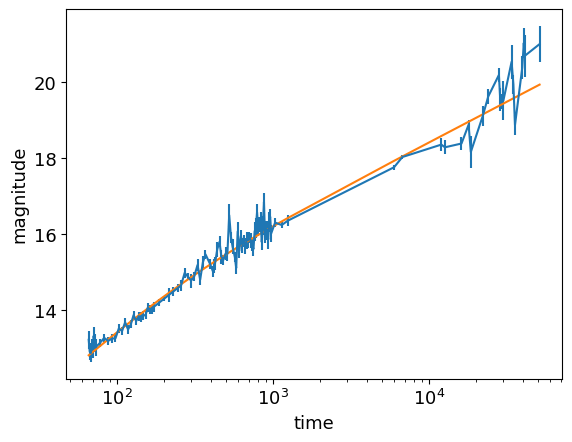

In [57]:

pl.errorbar(t, y, yerr=s)
pl.plot(t,bpl(mcmc_bpl[:,1], t))
pl.xscale("log")
plt.ylabel("magnitude")
plt.xlabel("time")
plt.show()

Figure 13: Data with normal (not flipped) axes and non-log time with MCMC fit. Again we see that the fit does look pretty good, this is just for better visualization not using the flipped axes.

## plot the marginalized posterior distributions of the parameters

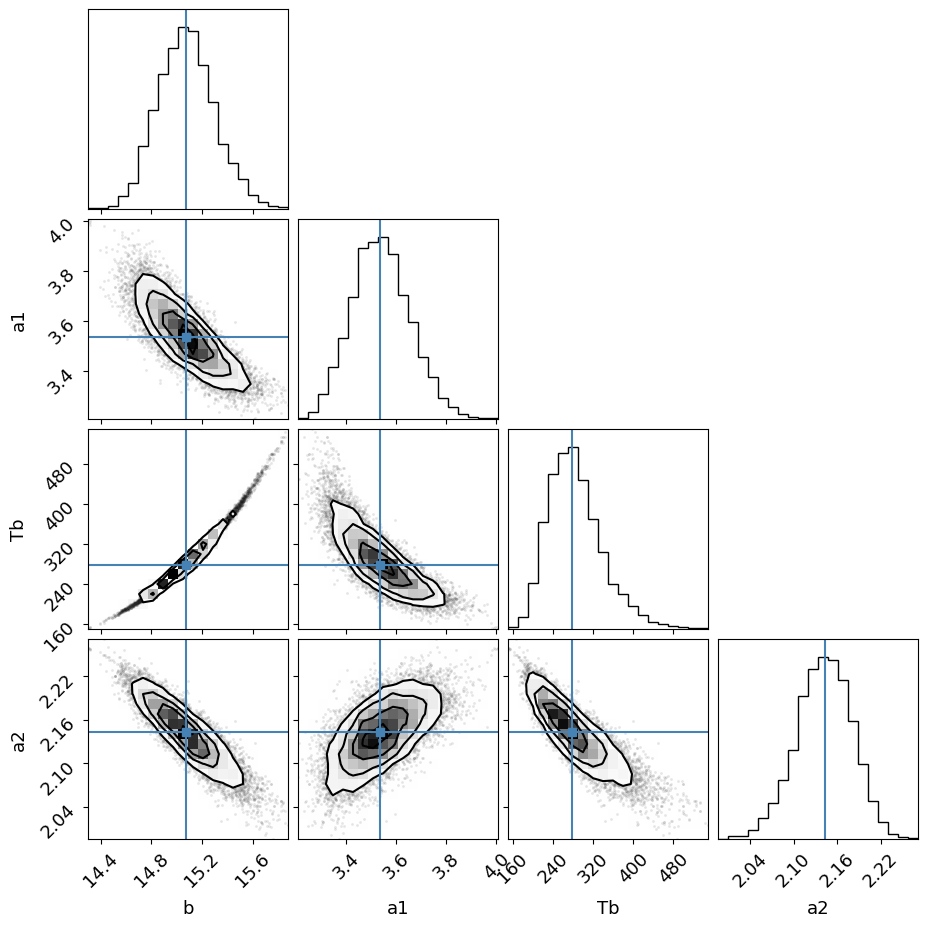

In [58]:

pl.rcParams["font.size"]= 13
fig = corner.corner(
    flat_samples_bpl, labels=["b", "a1", "Tb", "a2"], truths=mcmc_bpl[:,1]);



Figure 14: Corner plot for MCMC parameters. Each parameter has a pretty good looking contour structure. The wider contours like a1 v a2 indicate a lack of correlation between the variables. Interestingly, it seems that b and t_b are well correlated which I wouldn't necessarily expect, but I guess I'm not totally sure what the nuisance parameter means exactly.

# <mark>WFF</mark> Very nice!

# HW part 4: Compare the line (as obtained by the MCMC) and broken power law models. For this part of the assignment use the slides in part 2.2 of the current slide deck (slide column 8) https://slides.com/federicabianco/dsps_6#/8. in particular:

- Print the loglikelihood of each model (you can use the log_likelihood function you had written for each)
https://slides.com/federicabianco/dsps_6#/8/1 through https://slides.com/federicabianco/dsps_6#/8/3

- implement the caluculation of the AIC (https://slides.com/federicabianco/dsps_6#/8/4 through 6)
- and BIC (https://slides.com/federicabianco/dsps_6#/8/7)



In [132]:
print("Likelihood Ratio for the Line is: {:.2f}".format(log_likelihood(mcmc_line[:,1], x, y, s))) #control the decimal digits!

L1 = log_likelihood(mcmc_line[:,1], x, y, s)

Likelihood Ratio for the Line is: 317.42


In [133]:
print("Likelihood Ratio for the BPL is: {:.2f}".format(log_likelihood_bpl(mcmc_bpl[:,1], t, y, s)))

L2 = log_likelihood_bpl(mcmc_bpl[:,1], t, y, s)

Likelihood Ratio for the BPL is: 217.47


## Implement the likelihood ration test printing out the likelihood ration statistics

The likelihood-ratio test assesses the goodness of fit of two competing _nested_ statistical models based on the values of the likelihood $L$ where $M1$ is the restricted model (the parameter space is smaller, hence restricted), nested inside $M2$, the full model (the more complex one).

$ \lambda_\mathrm{LR}=-2\ln {\frac {L(M1(\theta_\mathrm{restricted}))}{L(M2(\theta_\mathrm{full}))}}$

This statistics is expexted to be $\chi2$ distributed following a $ch2$ distribution with d.o.f=difference in size of the parameter space in the two models (number of parameters in bpl model - number of parameters in line model).


In [134]:
from scipy.stats.distributions import chi2
def like_ratio_statistics(L1,L2,dof):
  '''
  calculate the likelihood ratio statistic, and then the p value using chi^2 with dof given by the difference in parameter #s for the two fits, and the LR statistic.
  '''
  lambda_LR = -2*np.log(L2/L1)
  p = chi2.sf(lambda_LR,dof)
  return p

In [135]:
like_ratio_statistics(L1,L2,2)

0.6851222262474875

p value of 0. 685 means we cannot reject the null hypothesis that the line is a better fit than the BPL.

## Calculate the AIC and BIC: Aikiki Information Criterion and Bayesian Information Criterion for the comparison of the same two models.


In [136]:
def aic(N,L,k):
  '''
  calculate the AIC score for a given model (from likelihood)
  '''
  return -2/N*-L+2/N*k #I am using negative log likelihood here (my likelihood is defined as positive so i take the negative)


def bic(N,L,k):
  '''
  calculate the BIC score for a given model (from likelihood)
  '''
  return  -2*-L+np.log(N)*k


In [137]:
print("AIC line {0:.2f} - AIC bpl {1:.2f}".format(aic(len(x), L1, 2),
                                      aic(len(t), L2, 4)))



AIC line 5.92 - AIC bpl 4.10


The AIC scores indicate that the BPL is a better fit

In [138]:
print("BIC line {0:.2f}".format(bic(len(x), L1, 2)))
print("BIC BPL {0:.2f}".format(bic(len(t), L2, 4)))

BIC line 644.21
BIC BPL 453.67


BIC indicates that BPL is a better fit than line also!

# Extra Credit
 redefine the chi2 that I have written above to take a n deg polynomial, fit it to the data, compare it to the BPL model